In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# коннект с гугл диском

# from google.colab import drive
# drive.mount("/content/drive/")
# gdrive_path = '/content/drive/MyDrive/Colab Notebooks/DL_HW/Data'

In [ ]:
!wget http://sereja.me/f/universum_compressed.tar
!tar xf universum_compressed.tar

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
import os
from PIL import Image

class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass
                #print('Could not load image:', filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y

In [5]:
transform_all = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

def to_grayscale(x):
    return 1 - (x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114).view(1, 128, 128)

In [6]:
# обучал на своем ноутбуке, для батча размера 64 не хватило памяти

dataset = ColorizationDataset('universum-photos', to_grayscale, transform_all)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

  0%|          | 0/1254 [00:00<?, ?it/s]

Добавим батчнормов и неагрессивных дропаутов

In [7]:
def Block_pool(channels_in, channels_out, p = 0.2):
    return nn.Sequential(
        nn.Conv2d(channels_in, channels_out, (3, 3), padding=1),
        nn.Dropout(p),
        nn.LeakyReLU(),
        nn.MaxPool2d((2, 2), stride = (2, 2)),
        nn.BatchNorm2d(channels_out),
        nn.LeakyReLU()
        
    )

def Block(channels_in, channels_out, p = 0.4):
    return nn.Sequential(
        nn.Conv2d(channels_in, channels_out, (3, 3), padding=1),
        nn.Dropout(p),
        nn.BatchNorm2d(channels_out),
        nn.LeakyReLU()
        
    )

In [8]:
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.preconcat = nn.Sequential( 
            Block_pool(1, 16),
            Block_pool(16, 32), 
            Block_pool(32, 64),             
            Block_pool(64, 128),           
            Block_pool(128, 256), 
            Block_pool(256, 512),
            nn.Upsample(scale_factor=2),
            Block(512, 512),       
            nn.Upsample(scale_factor=2),    
            Block(512, 512),            
            nn.Upsample(scale_factor=2), 
            Block(512, 256),
            nn.Upsample(scale_factor=2),
            Block(256, 256),
            nn.Upsample(scale_factor=2),
            Block(256, 128),
            nn.Upsample(scale_factor=2),
            Block(128, 64)     
        )
         
        self.postconcat = nn.Sequential(         
            nn.Conv2d(65, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.preconcat(x)
        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

In [9]:
lr = 1e-3

model = Colorizer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.L1Loss()

In [10]:
# этим будем перезаписывать словарь с параметрами каждые 10 эпох, чтоб ничего не потерялось
def save_state(path, filename, model, optimizer, loss, epoch):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, path + '/' + filename)

In [11]:
def to_numpy_image(img):
    return img.detach().cpu().view(3, 128, 128).transpose(0, 1).transpose(1, 2).numpy()

Здесь было обучение, были попытки обучить на 1000+ эпох, но по-видимому надо было совершенствовать архитектуру, потому как все сломалось и все фотографии просто покрывались артефактами (наверное переобучение).    
Обучение с MSELoss давало результаты хуже и тоже было остановлено. 

Финальная модель была обучена на 600 эпох, L1Loss .

In [ ]:
lr = 1e-3

model = Colorizer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.L1Loss()

history = []
for epoch in tqdm(range(600)):
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        colorized = model(x)
        loss = criterion(colorized, y)
        history.append(loss.item())
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        save_state('', 'colorizer_v2.pt',
                   model, optimizer, loss, epoch)
        print('\n')
        print(f'{history[-1]:.5f}')
        for t in range(350, 353):
            img_gray, img_true = dataset[t]
            img_pred = model(img_gray.to(device).view(1, 1, 128, 128))
            img_pred = to_numpy_image(img_pred)
            # теперь это numpy-евский ndarray размера (128, 128, 3)
            plt.figure(figsize=(10,10))
            
            plt.subplot(141)
            plt.axis('off')
            plt.set_cmap('Greys')
            plt.imshow(img_gray.reshape((128, 128)))

            plt.subplot(142)
            plt.axis('off')
            plt.imshow(img_pred.reshape((128, 128, 3)))

            plt.subplot(143)
            plt.axis('off')
            plt.imshow(to_numpy_image(img_true))
            
            plt.show()


In [20]:
# Закоменченные строки нужны, если хотим продолжить обучение при обрыве
# Оставлю их для себя

# lr = 1e-3

model = Colorizer().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# criterion = nn.L1Loss()
checkpoint = torch.load('colorizer_v2.pt')
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']



<All keys matched successfully>

**Самые интересные картинки ниже**

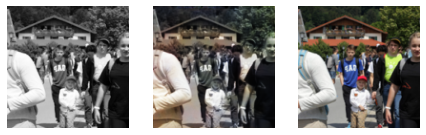

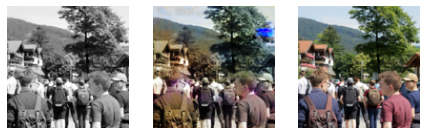

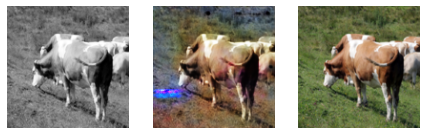

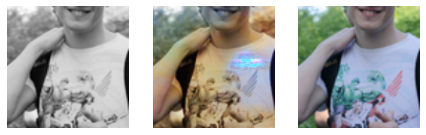

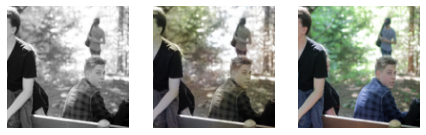

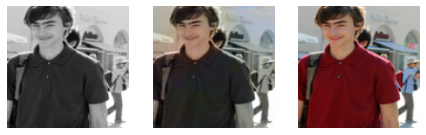

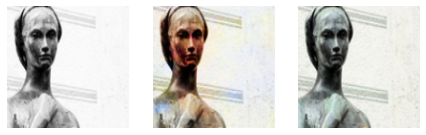

In [51]:
for t in [14, 20, 77, 116, 129, 872, 912]:
    img_gray, img_true = dataset[t]
    img_pred = model(img_gray.to(device).view(1, 1, 128, 128))
    img_pred = to_numpy_image(img_pred)
    # теперь это numpy-евский ndarray размера (128, 128, 3)
    plt.figure(figsize=(10,10))

    plt.subplot(141)
    plt.axis('off')
    plt.set_cmap('Greys')
    plt.imshow(img_gray.reshape((128, 128)))

    plt.subplot(142)
    plt.axis('off')
    plt.imshow(img_pred.reshape((128, 128, 3)))

    plt.subplot(143)
    plt.axis('off')
    plt.imshow(to_numpy_image(img_true))

    plt.show()

Дело в том, что изображения кропаются и тяжело словить хорошую подборку (не переписывая даталоадер). Здесь хорошо видны и проблемы и то, чему сетка уже обучилась.  
- В датасете было довольно много коров, поэтому сетка раскрашивает их довольно неплохо  
- Более-менее определяется тело и красится в телесный цвет, даже статуе достался более здоровый цвет лица.  
- Фотки отдают зеленым, в т.ч. лица. Результат не очень устойчивый, в этой подборке кажется что вообще не очень, хотя бывало лучше.
- Футболки у всех преимущественно черные и белые, поэтому их сильно не трогают. Но на 2й фотке справа человеку покрасило в красноватый цвет.